In [1]:
!pip install timm faiss-gpu

     |████████████████████████████████| 431 kB 919 kB/s            
     |████████████████████████████████| 85.5 MB 142 kB/s             


In [2]:
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import gc
from tqdm import tqdm
from fastai.vision.all import *
from fastai.vision.learner import _update_first_layer
import faiss
from timm import create_model
from timm.data.transforms_factory import create_transform
from sklearn.preprocessing import normalize

In [3]:
INPUT_DIR = Path("..") / "input"
OUTPUT_DIR = Path("/") / "kaggle" / "working"
DATA_ROOT_DIR = INPUT_DIR / "convert-backfintfrecords" / "happy-whale-and-dolphin-backfin"
TRAIN_DIR = DATA_ROOT_DIR / "train_images"
TEST_DIR = DATA_ROOT_DIR / "test_images"
TRAIN_CSV_PATH = DATA_ROOT_DIR / "train.csv"
SAMPLE_SUBMISSION_CSV_PATH = DATA_ROOT_DIR / "sample_submission.csv"
PUBLIC_SUBMISSION_CSV_PATH = INPUT_DIR / "0-720-eff-b5-640-rotate" / "submission.csv"
IDS_WITHOUT_BACKFIN_PATH = INPUT_DIR / "ids-without-backfin" / "ids_without_backfin.npy"
SUBMISSION_CSV_PATH = OUTPUT_DIR / "submission.csv"

# Loading dataset

In [4]:
train_csv = pd.read_csv('../input/happy-whale-and-dolphin/train.csv')
classes = list(train_csv.individual_id.unique())
train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(SAMPLE_SUBMISSION_CSV_PATH)
test_df.drop(columns=["predictions"], inplace=True)
test_df["individual_id"] = train_df.individual_id.unique()[0]
train_df["image_path"] = train_df["image"].apply(lambda x:TRAIN_DIR/str(x))
test_df["image_path"] = test_df["image"].apply(lambda x:TEST_DIR/str(x))

# Splitting data

In [5]:
N_SPLITS = 5
encoder = LabelEncoder()
train_df["label"] = encoder.fit_transform(train_df["individual_id"])
skf = StratifiedKFold(n_splits=N_SPLITS)

for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.individual_id)):
    train_df.loc[val_, "kfold"] = fold
    
train_df.drop('label',axis=1,inplace=True)
train_df.head()

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


,image,species,individual_id,image_path,kfold
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,../input/convert-backfintfrecords/happy-whale-and-dolphin-backfin/train_images/00021adfb725ed.jpg,0.0
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,../input/convert-backfintfrecords/happy-whale-and-dolphin-backfin/train_images/000562241d384d.jpg,1.0
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,../input/convert-backfintfrecords/happy-whale-and-dolphin-backfin/train_images/0007c33415ce37.jpg,0.0
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,../input/convert-backfintfrecords/happy-whale-and-dolphin-backfin/train_images/0007d9bca26a99.jpg,0.0
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,../input/convert-backfintfrecords/happy-whale-and-dolphin-backfin/train_images/00087baf5cef7a.jpg,0.0


In [6]:
len(train_df[train_df.kfold == 0])

8315

In [7]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# Creating dataloaders

In [8]:
Val_Fold = 0
def get_x(r): return r['image_path']
def get_y(r): return [r['individual_id']]
def splitter(df): 
    train = df.index[df.kfold != Val_Fold].tolist()
    valid = df.index[df.kfold == Val_Fold].tolist()
    return [train,valid]
def create_dls(df=train_df,bs=64,Val_Fold=0,Image_size=224):
    dblock = DataBlock(blocks = (ImageBlock,MultiCategoryBlock(vocab=classes)),
                       get_x = get_x,
                       get_y = get_y ,
                       splitter = splitter,
                       #item_tfms = [Resize(Image_size,method=ResizeMethod.Squish)],
                       item_tfms = [Resize(600)],
                       batch_tfms =[*aug_transforms(size=Image_size, max_warp=0), Normalize.from_stats(*imagenet_stats)]
                       #batch_tfms =[,Normalize.from_stats(*imagenet_stats)]
                      )

    dls = dblock.dataloaders(train_df,bs=bs)
    return dls

In [9]:
dls = create_dls()

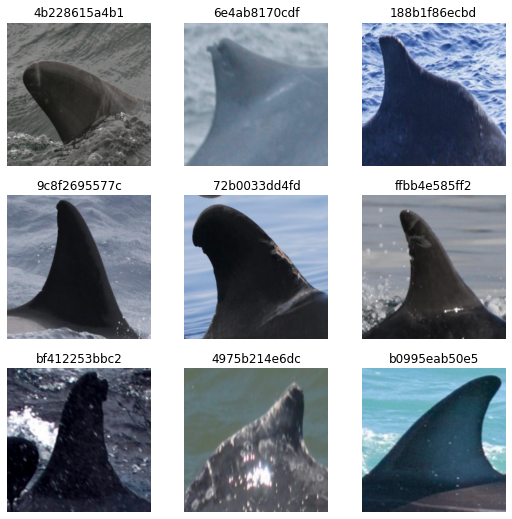

In [10]:
dls.show_batch()

In [11]:
target_map = {N:CLASS for N,CLASS in enumerate(dls.vocab)}

# Arc Face loss

In [12]:
# From https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/blob/master/src/modeling/metric_learning.py
# Added type annotations, device, and 16bit support
class ArcMarginLoss(Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        s: float,
        m: float,
        easy_margin: bool,
        ls_eps: float,
    ):
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, logits, targ):
        cosine = F.linear(F.normalize(logits), F.normalize(self.weight))
        # Enable 16 bit precision
        cosine = cosine.to(torch.float32)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        if self.ls_eps > 0:
            targ = (1 - self.ls_eps) * targ + self.ls_eps / self.out_features
        output = (targ * phi) + ((1.0 - targ) * cosine)
        output *= self.s
        loss =  F.cross_entropy(output, torch.argmax(targ, dim=1))
        return loss

# Creating the model

In [13]:
'''
class building_model(Module):
    def __init__(self,embedding_size:int,arch:str ='efficientnet_b0', pretrained:bool=True):
        self.model = create_model(arch, pretrained=pretrained)
        self.embedding = nn.Linear(self.model.get_classifier().in_features, embedding_size)
        self.model.reset_classifier(num_classes=0, global_pool="avg")
    def forward(self,x):
        features = self.model(x)
        embeddings = self.embedding(features)
        return embeddings
'''

'\nclass building_model(Module):\n    def __init__(self,embedding_size:int,arch:str =\'efficientnet_b0\', pretrained:bool=True):\n        self.model = create_model(arch, pretrained=pretrained)\n        self.embedding = nn.Linear(self.model.get_classifier().in_features, embedding_size)\n        self.model.reset_classifier(num_classes=0, global_pool="avg")\n    def forward(self,x):\n        features = self.model(x)\n        embeddings = self.embedding(features)\n        return embeddings\n'

In [14]:
#emb_size = 512
#model = building_model(emb_size,'efficientnet_b0',True)
#model = nn.Sequential(*list(model.children()))

In [15]:
def create_timm_body(arch:str, pretrained=True, drop_rate=0.0, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, drop_rate=drop_rate, 
                         num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [16]:
emb_size = 512
body = create_timm_body("convnext_small", pretrained=True, drop_rate=0.0)
nf = num_features_model(nn.Sequential(*body.children()))
head = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=1),nn.Flatten(),
                     nn.Linear(nf,emb_size,bias=False))

model = nn.Sequential(body, head)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_1k_224_ema.pth


In [17]:
loss_func = ArcMarginLoss(in_features=emb_size, out_features=dls.c,s=30.0,
                          m = 0.5, easy_margin=False, ls_eps=0.0)

In [18]:
dls = create_dls(bs=32,Image_size=320)
learn = Learner(dls,model, loss_func=loss_func, 
                splitter=default_split).to_fp16()
learn.freeze()
learn.summary()

Sequential (Input shape: 32 x 3 x 320 x 320)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 96 x 80 x 80   
Conv2d                                    4704       False     
LayerNorm2d                               192        True      
Identity                                                       
Conv2d                                    4800       False     
LayerNorm                                 192        True      
____________________________________________________________________________
                     32 x 80 x 80 x 384  
Linear                                    37248      False     
GELU                                                           
Dropout                                                        
____________________________________________________________________________
                     32 x 80 x 80 x 96   
Linear                                    36960      False     
Dropout                            

In [19]:
'''
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
     "Compute accuracy when `inp` and `targ` are the same size."
     if sigmoid: inp = inp.sigmoid()
     return ((inp>thresh)==targ.bool()).float().mean()
'''

'\ndef accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):\n     "Compute accuracy when `inp` and `targ` are the same size."\n     if sigmoid: inp = inp.sigmoid()\n     return ((inp>thresh)==targ.bool()).float().mean()\n'

In [20]:
#learn.lr_find()

In [21]:
learn.fit_one_cycle(1,lr_max=3e-4,wd=1e-6)

epoch,train_loss,valid_loss,time
0,23.612482,23.578835,18:26


In [22]:
learn.unfreeze()
learn.fit_one_cycle(9,lr_max=3e-4,wd=1e-6)

epoch,train_loss,valid_loss,time
0,22.607441,22.518724,22:52
1,20.262177,20.085552,22:51
2,18.099619,18.216286,22:50
3,15.719199,16.558453,22:53
4,13.289057,15.304122,22:50
5,11.270385,14.470010,22:53
6,9.647884,13.974173,22:52
7,8.821856,13.803380,22:52
8,8.277028,13.779884,22:52


In [23]:
learn.export('model.pkl')

In [24]:
del learn
torch.cuda.empty_cache()
gc.collect()

33279

In [25]:
def load_eval_learner(learner_path,output_group,dls,device):
    learn = load_learner(learner_path)
    learn.model.to(device)
    learn.dls = dls
    hook = Hook(learn.model[output_group], lambda m,i,o: o)
    return learn, hook

def load_dataloaders(train_df,test_df,val_fold,dls):
    train_dataloader = dls.test_dl(train_df[train_df.kfold != val_fold],with_labels=True)
    valid_dataloader = dls.test_dl(train_df[train_df.kfold == val_fold],with_labels=True)
    test_dataloader  = dls.test_dl(test_df,with_labels=True)
    return train_dataloader, valid_dataloader, test_dataloader

@torch.inference_mode()
def get_embeddings(module, dataloader, device):

    all_image_names = []
    all_embeddings = []
    all_targets = []

    for (x, y) in tqdm(dataloader):
        images =  x.to(device)
        targets = y.to(device)
        embeddings = module.model(images)
        all_embeddings.append(embeddings.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    all_image_names = dataloader.items['image'].values
    all_embeddings = np.vstack(all_embeddings)
    all_targets = np.concatenate(all_targets)
    all_targets = L(list(np.argmax(all_targets,axis=1)))
    all_embeddings = normalize(all_embeddings, axis=1, norm="l2")
    all_targets = np.array(all_targets.map(target_map.__getitem__))
    return all_image_names, all_embeddings, all_targets

def create_and_search_index(embedding_size: int, train_embeddings: np.ndarray, val_embeddings: np.ndarray, k: int):
    index = faiss.IndexFlatIP(embedding_size)
    index.add(train_embeddings)
    D, I = index.search(val_embeddings, k=k)  # noqa: E741

    return D, I

def create_val_targets_df(
    train_targets: np.ndarray, val_image_names: np.ndarray, val_targets: np.ndarray
) -> pd.DataFrame:

    allowed_targets = np.unique(train_targets)
    val_targets_df = pd.DataFrame(np.stack([val_image_names, val_targets], axis=1), columns=["image", "target"])
    val_targets_df.loc[~val_targets_df.target.isin(allowed_targets), "target"] = "new_individual"

    return val_targets_df

def create_distances_df(
    image_names: np.ndarray, targets: np.ndarray, D: np.ndarray, I: np.ndarray, stage: str  # noqa: E741
) -> pd.DataFrame:
    distances_df = []
    for i, image_name in tqdm(enumerate(image_names), desc=f"Creating {stage}_df"):
        target = targets[I[i]]
        distances = D[i]
        subset_preds = pd.DataFrame(np.stack([target, distances], axis=1), columns=["target", "distances"])
        subset_preds["image"] = image_name
        distances_df.append(subset_preds)
    distances_df = pd.concat(distances_df).reset_index(drop=True)
    distances_df = distances_df.groupby(["image", "target"]).distances.max().reset_index()
    distances_df = distances_df.sort_values("distances", ascending=False).reset_index(drop=True)
    return distances_df

def get_best_threshold(val_targets_df: pd.DataFrame, valid_df: pd.DataFrame):
    best_th = 0
    best_cv = 0
    for th in [0.1 * x for x in range(11)]:
        all_preds = get_predictions(valid_df, threshold=th)

        cv = 0
        for i, row in val_targets_df.iterrows():
            target = row.target
            preds = all_preds[row.image]
            val_targets_df.loc[i, th] = map_per_image(target, preds)

        cv = val_targets_df[th].mean()

        print(f"th={th} cv={cv}")

        if cv > best_cv:
            best_th = th
            best_cv = cv

    print(f"best_th={best_th}")
    print(f"best_cv={best_cv}")

    # Adjustment: Since Public lb has nearly 10% 'new_individual' (Be Careful for private LB)
    val_targets_df["is_new_individual"] = val_targets_df.target == "new_individual"
    val_scores = val_targets_df.groupby("is_new_individual").mean().T
    val_scores["adjusted_cv"] = val_scores[True] * 0.1 + val_scores[False] * 0.9
    best_th = val_scores["adjusted_cv"].idxmax()
    print(f"best_th_adjusted={best_th}")

    return best_th, best_cv

def get_predictions(df: pd.DataFrame, threshold: float = 0.2):
    sample_list = ["938b7e931166", "5bf17305f073", "7593d2aee842", "7362d7a01d00", "956562ff2888"]
    predictions = {}
    for i, row in tqdm(df.iterrows(), total=len(df), desc=f"Creating predictions for threshold={threshold}"):
        if row.image in predictions:
            if len(predictions[row.image]) == 5:
                continue
            predictions[row.image].append(row.target)
        elif float(row.distances) > threshold:
            predictions[row.image] = [row.target, "new_individual"]
        else:
            predictions[row.image] = ["new_individual", row.target]

    for x in tqdm(predictions):
        if len(predictions[x]) < 5:
            remaining = [y for y in sample_list if y not in predictions]
            predictions[x] = predictions[x] + remaining
            predictions[x] = predictions[x][:5]

    return predictions

def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0


def create_predictions_df(test_df: pd.DataFrame, best_th: float) -> pd.DataFrame:
    predictions = get_predictions(test_df, best_th)

    predictions = pd.Series(predictions).reset_index()
    predictions.columns = ["image", "predictions"]
    predictions["predictions"] = predictions["predictions"].apply(lambda x: " ".join(x))

    return predictions

In [26]:
def infer(
    model_path: str,
    dls: DataLoader,
    train_df: pd.DataFrame = train_df,
    test_df: pd.DataFrame = test_df,
    val_fold: float = 0.0,
    k: int = 50,
    emb_size:int = emb_size
):
    (learn, hook) = load_eval_learner(model_path,1,dls,torch.device("cuda"))
    train_dl, val_dl, test_dl = load_dataloaders(train_df,test_df,val_fold,dls)

    train_image_names, train_embeddings, train_targets = get_embeddings(learn, train_dl,torch.device("cuda"))
    val_image_names, val_embeddings, val_targets = get_embeddings(learn, val_dl,torch.device("cuda"))
    test_image_names, test_embeddings, test_targets = get_embeddings(learn, test_dl,torch.device("cuda"))

    D, I = create_and_search_index(emb_size, train_embeddings, val_embeddings, k)  # noqa: E741
    print("Created index with train_embeddings")
    
    val_targets_df = create_val_targets_df(train_targets, val_image_names, val_targets)
    print(f"val_targets_df=\n{val_targets_df.head()}")
    print(f"val_targets_df shape=\n{val_targets_df.shape}")
    val_df = create_distances_df(val_image_names, train_targets, D, I, "val")
    print(f"val_df=\n{val_df.head()}")
    print(f"val_df shape=\n{val_df.shape}")
    best_th, best_cv = get_best_threshold(val_targets_df, val_df)
    print(f"val_targets_df=\n{val_targets_df.describe()}")
    print(f"val_targets_df shape=\n{val_targets_df.shape}")
    train_embeddings = np.concatenate([train_embeddings, val_embeddings])
    train_targets = np.concatenate([train_targets, val_targets])
    print("Updated train_embeddings and train_targets with val data")

    D, I = create_and_search_index(emb_size, train_embeddings, test_embeddings, k)  # noqa: E741
    print("Created index with train_embeddings")

    test_df = create_distances_df(test_image_names, train_targets, D, I, "test")
    print(f"test_df=\n{test_df.head()}")
    print(f"test_df shape=\n{test_df.shape}")

    predictions = create_predictions_df(test_df, best_th)
    print(f"predictions.head()={predictions.head()}")
    print(f"predictions shape={predictions.shape}")
 
    # Fix missing predictions
    # From https://www.kaggle.com/code/jpbremer/backfins-arcface-tpu-effnet/notebook
    public_predictions = pd.read_csv(PUBLIC_SUBMISSION_CSV_PATH)
    ids_without_backfin = np.load(IDS_WITHOUT_BACKFIN_PATH, allow_pickle=True)

    ids2 = public_predictions["image"][~public_predictions["image"].isin(predictions["image"])]

    predictions = pd.concat(
        [
            predictions[~(predictions["image"].isin(ids_without_backfin))],
            public_predictions[public_predictions["image"].isin(ids_without_backfin)],
            public_predictions[public_predictions["image"].isin(ids2)],
        ]
    )
    predictions = predictions.drop_duplicates()

    predictions.to_csv(SUBMISSION_CSV_PATH, index=False)

In [27]:
infer(model_path="model.pkl",dls=dls)

100%|██████████| 874/874 [07:48<00:00,  1.86it/s]


Created index with train_embeddings
val_targets_df=
                image          target
0  00021adfb725ed.jpg  new_individual
1  0007c33415ce37.jpg    60008f293a2b
2  0007d9bca26a99.jpg    4b00fe572063
3  00087baf5cef7a.jpg    8e5253662392
4  000a8f2d5c316a.jpg    b9907151f66e
val_targets_df shape=
(8315, 2)


Creating val_df: 8315it [00:05, 1468.82it/s]


val_df=
                image        target   distances
0  27eed76d08871e.jpg  62ec6fea7ad5   0.9996788
1  08a8f393e99633.jpg  37c7aba965a5    0.998724
2  2ce59f67dc3390.jpg  37c7aba965a5   0.9984516
3  2778fe05a122d9.jpg  37c7aba965a5  0.99818075
4  05b9a41635a275.jpg  ca69a5d7c122   0.9981592
val_df shape=
(181914, 3)


100%|██████████| 8315/8315 [00:00<00:00, 655064.57it/s]


th=0.0 cv=0.7131870114251326


100%|██████████| 8315/8315 [00:00<00:00, 767949.04it/s]


th=0.1 cv=0.7131870114251326


100%|██████████| 8315/8315 [00:00<00:00, 631965.31it/s]


th=0.2 cv=0.7131870114251326


Creating predictions for threshold=0.30000000000000004: 100%|██████████| 181914/181914 [00:11<00:00, 15547.86it/s]
100%|██████████| 8315/8315 [00:00<00:00, 875722.23it/s]


th=0.30000000000000004 cv=0.7339326518340321


100%|██████████| 8315/8315 [00:00<00:00, 708638.38it/s]


th=0.4 cv=0.774582080577267


100%|██████████| 8315/8315 [00:00<00:00, 874668.01it/s]


th=0.5 cv=0.7760853878532745


Creating predictions for threshold=0.6000000000000001: 100%|██████████| 181914/181914 [00:11<00:00, 16205.84it/s]
100%|██████████| 8315/8315 [00:00<00:00, 877595.31it/s]


th=0.6000000000000001 cv=0.7578051713770267


Creating predictions for threshold=0.7000000000000001: 100%|██████████| 181914/181914 [00:11<00:00, 15280.69it/s]
100%|██████████| 8315/8315 [00:00<00:00, 820950.94it/s]


th=0.7000000000000001 cv=0.7320685508117838


100%|██████████| 8315/8315 [00:00<00:00, 845982.72it/s]


th=0.8 cv=0.6977330126277792


100%|██████████| 8315/8315 [00:00<00:00, 833866.63it/s]


th=0.9 cv=0.6477630787733003


100%|██████████| 8315/8315 [00:00<00:00, 699274.93it/s]


th=1.0 cv=0.5162537582681908
best_th=0.5
best_cv=0.7760853878532745
best_th_adjusted=0.4
val_targets_df=
               0.0          0.1          0.2  0.30000000000000004  \
count  8315.000000  8315.000000  8315.000000          8315.000000   
mean      0.713187     0.713187     0.713187             0.733933   
std       0.379635     0.379635     0.379635             0.381077   
min       0.000000     0.000000     0.000000             0.000000   
25%       0.500000     0.500000     0.500000             0.500000   
50%       1.000000     1.000000     1.000000             1.000000   
75%       1.000000     1.000000     1.000000             1.000000   
max       1.000000     1.000000     1.000000             1.000000   

               0.4          0.5  0.6000000000000001  0.7000000000000001  \
count  8315.000000  8315.000000         8315.000000         8315.000000   
mean      0.774582     0.776085            0.757805            0.732069   
std       0.380623     0.380523            0.381

Creating test_df: 27942it [00:17, 1595.04it/s]


test_df=
                image        target   distances
0  5fb61ff7e07076.jpg  2e0b381d3467   0.9968258
1  a3f60cad2aae2d.jpg  e8ac23241df5   0.9956312
2  bd8959890b900f.jpg  c995c043c353   0.9952357
3  797bae1ac53abb.jpg  c995c043c353  0.99510986
4  1edaf5f3e60221.jpg  be330f0c495c  0.99351287
test_df shape=
(676966, 3)


100%|██████████| 27942/27942 [00:00<00:00, 1050116.86it/s]


predictions.head()=                image  \
0  5fb61ff7e07076.jpg   
1  a3f60cad2aae2d.jpg   
2  bd8959890b900f.jpg   
3  797bae1ac53abb.jpg   
4  1edaf5f3e60221.jpg   

                                                          predictions  
0  2e0b381d3467 new_individual 938b7e931166 5bf17305f073 7593d2aee842  
1  e8ac23241df5 new_individual 2c6dd2efff3b d523f02b8e96 ac464169f6e9  
2  c995c043c353 new_individual 938b7e931166 5bf17305f073 7593d2aee842  
3  c995c043c353 new_individual 938b7e931166 5bf17305f073 7593d2aee842  
4  be330f0c495c new_individual 938b7e931166 5bf17305f073 7593d2aee842  
predictions shape=(27942, 2)


In [28]:
'''
bs = 32
for Fold in range(N_SPLITS):
    print(f'Epoch-{Fold}')
    dls = create_dls(Val_Fold=Fold,bs=bs)
    learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi,thresh=0.2))
    learn = learn.to_fp16()
    learn.fit_one_cycle(1,lr_max=slice(2.2e-6, 2e-4))
    learn.export(f'learn{Fold}.pkl')
    del learn
    torch.cuda.empty_cache()
    gc.collect()
'''

"\nbs = 32\nfor Fold in range(N_SPLITS):\n    print(f'Epoch-{Fold}')\n    dls = create_dls(Val_Fold=Fold,bs=bs)\n    learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi,thresh=0.2))\n    learn = learn.to_fp16()\n    learn.fit_one_cycle(1,lr_max=slice(2.2e-6, 2e-4))\n    learn.export(f'learn{Fold}.pkl')\n    del learn\n    torch.cuda.empty_cache()\n    gc.collect()\n"